### Librerías

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install torchmetrics
!pip install torcheval

import os

import random
import numpy as np
import pandas as pd


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torchsummary
import torch.optim as optim

from tqdm import tqdm

from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

from sklearn.metrics import precision_score, recall_score, accuracy_score


from matplotlib import pyplot as plt

from PIL import Image






Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Cargar imágenes y sus targets

In [ ]:
# Descargar y descromprimir el dataset de imágenes de fondo de ojo.
!gdown 1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS
!unzip /home/cristina/Documentos/ESPECIALIDAD_IA/vision2/Training/preprocessed_images.zip
#!unzip /content/preprocessed_images.zip -d ./preprocessed_images

# Descargar .csv que contiene los targets para cada imagen.
!gdown 1xe5Qzvqjzwlspm24um4sfnvY1RwL6c2h

Downloading...
From (original): https://drive.google.com/uc?id=1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS
From (redirected): https://drive.google.com/uc?id=1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS&confirm=t&uuid=3ba67962-85ff-424f-8174-7319660f87ed
To: /home/cristina/Documentos/ESPECIALIDAD_IA/vision2/Training/preprocessed_images.zip
 90%|███████████████████████████████████▉    | 354M/394M [00:05<00:00, 59.3MB/s]

### Instanciar dataset y dataloaders

In [2]:
class FundusDataset(Dataset):
    '''
    Custom Dataset para la carga de las imágenes de fondo de ojo con sus respectivos targets.
    Targets y sus significados:
    0 - Normal
    1 - Diabetes
    2 - Glaucoma
    3 - Cataratas
    4 - Degeneración macular asociada a la edad
    5 - Hipertensión
    6 - Miopía
    7 - Otras enfermedades o anormalidades
    '''
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

        # Eliminar columnas redundantes
        self.df = self.df.drop(columns=['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'])

        # Convertir one-hot encoded 'target' a integer class labels
        self.df['target'] = self.df['target'].apply(lambda x: torch.argmax(torch.tensor(eval(x))))
        #class_mapping = {'N': 0, 'D': 1, 'G': 2, 'C': 3, 'A': 4, 'H': 5, 'M': 6, 'O': 7}
        #self.df['target'] = self.df['target'].map(class_mapping)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        
        img_name = os.path.join(self.root_dir, str(self.df.iloc[idx, self.df.columns.get_loc('filename')]))
        image = Image.open(img_name)
        #image = self.to_tensor(image)

        target_value = self.df.iloc[idx]['target']
        if not isinstance(target_value, torch.Tensor):
            label = torch.tensor(target_value).clone().detach()
        else:
            label = target_value.clone().detach()
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
     

    def _map_label_to_target(self, label):
        if label == '[\'N\']':
            return 0
            #return [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'D\']':
            return 1
            #return [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'G\']':
            return 2
            #return [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'C\']':
            return 3
            #return [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'A\']':
            return 4
            #return [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
        elif label == '[\'H\']':
            return 5
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
        elif label == '[\'M\']':
            return 6
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        elif label == '[\'O\']':
            return 7
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
        else:
            raise Exception('Target desconocido')

class TransformedDataset(Dataset):
    def __init__(self, original_dataset, transform):
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Leer el dataframe que contiene los targets para cada imagen.
full_df = pd.read_csv('full_df.csv')

# Instanciar el dataset.
dataset = FundusDataset(csv_file='full_df.csv', root_dir='preprocessed_images/')

# Dividir el dataset en entrenamiento y testing.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_dataset = TransformedDataset(train_dataset, transform=data_transforms)
test_dataset = TransformedDataset(test_dataset, transform=data_transforms)

# Instanciar dataloaders para ambos subsets.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificar shapes de los batches de entrenamiento.
train_features, train_labels = next(iter(train_dataloader))
print(f'Train feature batch shape: {train_features.size()}')
print(f'Train labels batch shape: {train_labels.size()}')

# Verificar shapes de los batches de testing.
test_features, test_labels = next(iter(test_dataloader))
print(f'Test feature batch shape: {test_features.size()}')
print(f'Test labels batch shape: {test_labels.size()}')




Train feature batch shape: torch.Size([32, 3, 224, 224])
Train labels batch shape: torch.Size([32])
Test feature batch shape: torch.Size([32, 3, 224, 224])
Test labels batch shape: torch.Size([32])


### Funciones de Entrenamiento

In [3]:
def train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, num_classes=8, early_stopping=False, patience=5):
    if early_stopping:
        best_loss = float('inf')
        no_improvement_count = 0

    accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
    precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)

    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
      
        
        for images, labels in tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            

            accuracy.update(predicted, labels)
            precision.update(predicted, labels)
            recall.update(predicted, labels)

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)
        train_accuracy = accuracy.compute()
        train_accuracies.append(train_accuracy)
        train_precision = precision.compute()
        train_precisions.append(train_precision)
        train_recall = recall.compute()
        train_recalls.append(train_recall)

            #train_predictions.extend(predicted.cpu().tolist())
            #train_targets.extend(labels.cpu().tolist())



        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}')

        # Evaluación del modelo en el conjunto de datos de prueba
        model.eval()
        test_correct = 0
        test_total = 0
        test_predictions = []
        test_targets = []
        with torch.no_grad():
            for images, labels in tqdm(test_dataloader, desc=f'Testing Epoch {epoch + 1}/{num_epochs}', unit='batch'):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
              

                accuracy.update(predicted, labels)
                precision.update(predicted, labels)
                recall.update(predicted, labels)

                #test_predictions.extend(predicted.cpu().tolist())
                #test_targets.extend(labels.cpu().tolist())
        test_loss = running_loss/len(test_dataloader)
        test_losses.append(test_loss)
        test_accuracy = accuracy.compute()
        test_accuracies.append(test_accuracy)
        test_precision = precision.compute()
        test_precisions.append(test_precision)
        test_recall = recall.compute()
        test_recalls.append(test_recall)

        print(f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}, Testing Precision: {test_precision:.4f}, Testing Recall: {test_recall:.4f}')

        if early_stopping:
            if test_loss < best_loss:
                best_loss = test_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= patience:
                print(f'No improvement for {patience} epochs. Early stopping...')
                break

    return train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls



In [23]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls):
    epochs = range(1, len(train_losses) + 1)


    # Convertir tensores a valores flotantes
    train_accuracies = [accuracy.item() for accuracy in train_accuracies]
    test_accuracies = [accuracy.item() for accuracy in test_accuracies]
    train_precisions = [precision.item() for precision in train_precisions]
    test_precisions = [precision.item() for precision in test_precisions]
    train_recalls = [recall.item() for recall in train_recalls]
    test_recalls = [recall.item() for recall in test_recalls]

  

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    # Plot loss
    axes[0, 0].plot(epochs, train_losses, label='Training Loss')
    axes[0, 0].plot(epochs, test_losses, label='Testing Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Plot accuracy
    axes[0, 1].plot(epochs, train_accuracies, label='Training Accuracy')
    axes[0, 1].plot(epochs, test_accuracies, label='Testing Accuracy')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Plot precision
    axes[1, 0].plot(epochs, train_precisions, label='Training Precision')
    axes[1, 0].plot(epochs, test_precisions, label='Testing Precision')
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()

    # Plot recall
    axes[1, 1].plot(epochs, train_recalls, label='Training Recall')
    axes[1, 1].plot(epochs, test_recalls, label='Testing Recall')
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()




### VGGNet16 con fine-tunning

In [5]:
# Definir el modelo VGGNet con fine-tuning
class VGGNetFineTuning(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetFineTuning, self).__init__()
        vgg = models.vgg16(models.VGG16_Weights.DEFAULT)
        for param in vgg.parameters():
            param.requires_grad = False
        # Modificar la capa de clasificación
        vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)
        self.vgg = vgg

    def forward(self, x):
        return self.vgg(x)


In [6]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFineTuning(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)


/home/cristina/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Training Epoch 1/100: 100%|████████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 1.4240, Training Accuracy: 0.2941, Training Precision: 0.3119, Training Recall: 0.2941


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 5.6961, Testing Accuracy: 0.3061, Testing Precision: 0.3570, Testing Recall: 0.3061


Training Epoch 2/100: 100%|████████████████| 160/160 [00:36<00:00,  4.34batch/s]


Training Loss: 1.3319, Training Accuracy: 0.3226, Training Precision: 0.3766, Training Recall: 0.3226


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 5.3275, Testing Accuracy: 0.3276, Testing Precision: 0.3833, Testing Recall: 0.3276


Training Epoch 3/100: 100%|████████████████| 160/160 [00:36<00:00,  4.33batch/s]


Training Loss: 1.2819, Training Accuracy: 0.3399, Training Precision: 0.3984, Training Recall: 0.3399


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 5.1277, Testing Accuracy: 0.3420, Testing Precision: 0.3999, Testing Recall: 0.3420


Training Epoch 4/100: 100%|████████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 1.2959, Training Accuracy: 0.3486, Training Precision: 0.4076, Training Recall: 0.3486


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 5.1835, Testing Accuracy: 0.3507, Testing Precision: 0.4104, Testing Recall: 0.3507


Training Epoch 5/100: 100%|████████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 1.2884, Training Accuracy: 0.3548, Training Precision: 0.4144, Training Recall: 0.3548


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 5.1535, Testing Accuracy: 0.3551, Testing Precision: 0.4163, Testing Recall: 0.3551


Training Epoch 6/100: 100%|████████████████| 160/160 [00:37<00:00,  4.32batch/s]


Training Loss: 1.2926, Training Accuracy: 0.3607, Training Precision: 0.4268, Training Recall: 0.3607


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 5.1705, Testing Accuracy: 0.3616, Testing Precision: 0.4273, Testing Recall: 0.3616


Training Epoch 7/100: 100%|████████████████| 160/160 [00:36<00:00,  4.43batch/s]


Training Loss: 1.2690, Training Accuracy: 0.3660, Training Precision: 0.4317, Training Recall: 0.3660


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.53batch/s]


Testing Loss: 5.0762, Testing Accuracy: 0.3659, Testing Precision: 0.4330, Testing Recall: 0.3659


Training Epoch 8/100: 100%|████████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 1.2791, Training Accuracy: 0.3670, Training Precision: 0.4297, Training Recall: 0.3670


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 5.1166, Testing Accuracy: 0.3665, Testing Precision: 0.4310, Testing Recall: 0.3665


Training Epoch 9/100: 100%|████████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 1.2956, Training Accuracy: 0.3690, Training Precision: 0.4338, Training Recall: 0.3690


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 5.1822, Testing Accuracy: 0.3694, Testing Precision: 0.4347, Testing Recall: 0.3694


Training Epoch 10/100: 100%|███████████████| 160/160 [00:36<00:00,  4.35batch/s]


Training Loss: 1.2863, Training Accuracy: 0.3724, Training Precision: 0.4378, Training Recall: 0.3724


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 5.1453, Testing Accuracy: 0.3720, Testing Precision: 0.4385, Testing Recall: 0.3720


Training Epoch 11/100: 100%|███████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 1.2700, Training Accuracy: 0.3743, Training Precision: 0.4401, Training Recall: 0.3743


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 5.0798, Testing Accuracy: 0.3747, Testing Precision: 0.4402, Testing Recall: 0.3747


Training Epoch 12/100: 100%|███████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 1.2524, Training Accuracy: 0.3768, Training Precision: 0.4437, Training Recall: 0.3768


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 5.0098, Testing Accuracy: 0.3768, Testing Precision: 0.4436, Testing Recall: 0.3768


Training Epoch 13/100: 100%|███████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 1.2765, Training Accuracy: 0.3783, Training Precision: 0.4438, Training Recall: 0.3783


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 5.1061, Testing Accuracy: 0.3778, Testing Precision: 0.4438, Testing Recall: 0.3778


Training Epoch 14/100: 100%|███████████████| 160/160 [00:35<00:00,  4.48batch/s]


Training Loss: 1.2674, Training Accuracy: 0.3797, Training Precision: 0.4463, Training Recall: 0.3797


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 5.0696, Testing Accuracy: 0.3794, Testing Precision: 0.4467, Testing Recall: 0.3794


Training Epoch 15/100: 100%|███████████████| 160/160 [00:36<00:00,  4.41batch/s]


Training Loss: 1.2853, Training Accuracy: 0.3811, Training Precision: 0.4472, Training Recall: 0.3811


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 5.1411, Testing Accuracy: 0.3807, Testing Precision: 0.4469, Testing Recall: 0.3807


Training Epoch 16/100: 100%|███████████████| 160/160 [00:37<00:00,  4.30batch/s]


Training Loss: 1.2692, Training Accuracy: 0.3826, Training Precision: 0.4489, Training Recall: 0.3826


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 5.0769, Testing Accuracy: 0.3825, Testing Precision: 0.4486, Testing Recall: 0.3825


Training Epoch 17/100: 100%|███████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 1.2767, Training Accuracy: 0.3835, Training Precision: 0.4489, Training Recall: 0.3835


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]

Testing Loss: 5.1070, Testing Accuracy: 0.3837, Testing Precision: 0.4488, Testing Recall: 0.3837
No improvement for 5 epochs. Early stopping...


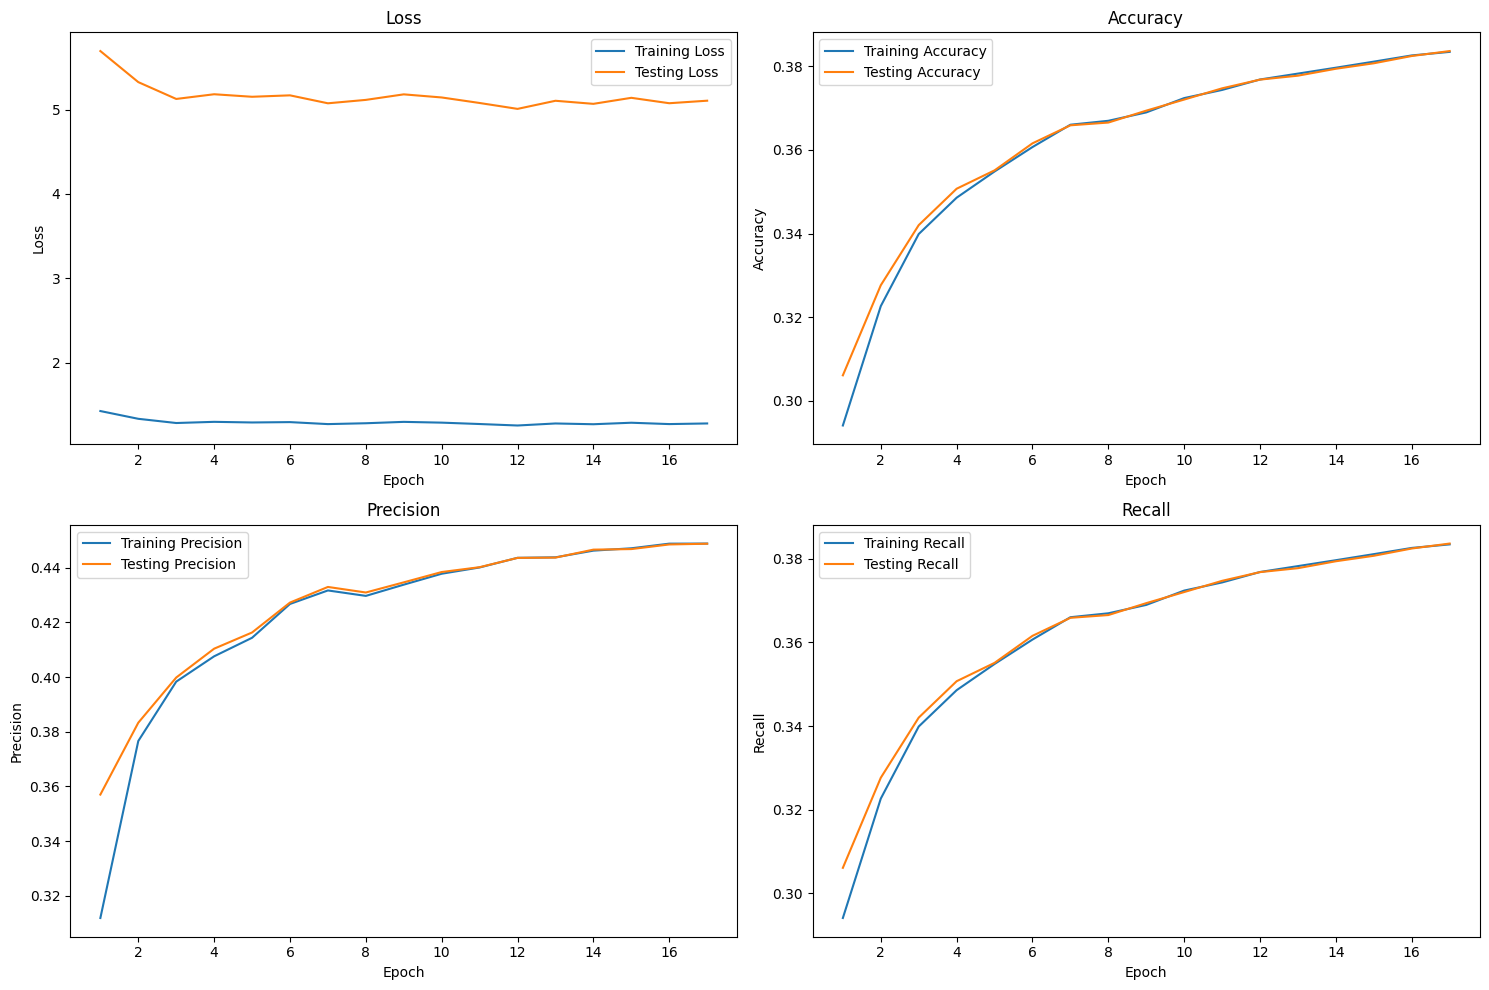

In [24]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [27]:
def compare_predictions(model, dataloader, device, class_names, num_samples=1):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(num_samples):
            expected_class = class_names[labels[i].item()]
            predicted_class = class_names[predicted[i].item()]
            print(f'Expected: {expected_class}, Predicted: {predicted_class}')

# Diccionario de mapeo de índices de clases a nombres de enfermedades
class_names = {
    0: 'Normal',
    1: 'Diabetes',
    2: 'Glaucoma',
    3: 'Cataratas',
    4: 'Degeneración macular asociada a la edad',
    5: 'Hipertensión',
    6: 'Miopía',
    7: 'Otras enfermedades o anormalidades'
}




In [29]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Cataratas, Predicted: Cataratas
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Glaucoma, Predicted: Normal
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Glaucoma, Predicted: Normal
